In [ ]:
#This script implements the LGAR model described in the paper "Layered Green and Ampt Infiltration With Redistribution"
#Luc Muller 06/11/2024

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.optimize import toms748


In [2]:
# Define the Layer class
class Layer:
    def __init__(self, Z, L, n, m, alpha, Ks, teta_s, teta_r, psi_init):
        self.Z = Z
        self.L = L
        self.n = n
        self.m = m
        self.alpha = alpha
        self.Ks = Ks
        self.teta_s = teta_s
        self.teta_r = teta_r
        self.psi_init = psi_init

        self.integral_lookup_K_from_psi = None
        self.teta_lookup_psi = None
        self.psi_min = -5000
        self.psi_max = 0
        self.precalculate_integral_K_from_psi(10*abs(self.psi_min-self.psi_max))
        self.precalculate_teta_lookup_psi(10*abs(self.psi_min-self.psi_max))



    def __repr__(self):
        return (f"Layer(L={self.L}, n={self.n}, alpha={self.alpha}, "
                f"Ks={self.Ks}, teta_s={self.teta_s}, teta_r={self.teta_r})")
    
    def K_from_psi(self, psi):
        return self.K_from_TETA(self.TETA_from_psi(psi))
    
    def teta_from_psi(self, psi):
        return self.teta_r + (self.teta_s - self.teta_r) / (1 + abs(self.alpha * psi) ** self.n) ** self.m
    
    def TETA_from_psi(self, psi):
        return (1+abs(self.alpha*psi)**self.n)**(-self.m)
    
    def teta_from_TETA(self, TETA):
        return self.teta_r + (self.teta_s - self.teta_r) * TETA
    
    def TETA_from_teta(self, teta):
        return (teta - self.teta_r) / (self.teta_s - self.teta_r)
    
    def psi_from_TETA(self, TETA):
        return -(TETA ** (-1 / self.m) - 1) ** (1 / self.n) / abs(self.alpha)
    
    def K_from_TETA(self, TETA):
        return self.Ks * TETA ** 0.5 * (1 - (1 - TETA ** (1 / self.m)) ** self.m) ** 2
    
    def precalculate_integral_K_from_psi(self, num_points=1000):
        psi_min = self.psi_min
        psi_max = self.psi_max
        psi_values = np.linspace(psi_min, psi_max, num_points)
        
        integral_values = [quad(self.K_from_psi, psi_min, psi)[0] for psi in psi_values]
        self.integral_lookup_K_from_psi = interp1d(psi_values, integral_values, kind='cubic', fill_value="extrapolate")

        
    def get_K_integral_from_teta(self, teta_start, teta_end):
        if self.integral_lookup_K_from_psi is None:
            raise ValueError("Integral lookup table has not been precalculated.")
        psi_end = self.psi_from_TETA(self.TETA_from_teta(teta_end))
        psi_start = self.psi_from_TETA(self.TETA_from_teta(teta_start))
        if psi_end > self.psi_max:
            raise ValueError("psi_end is greater than the maximum value of psi.")
        if psi_start < self.psi_min:
            raise ValueError("psi_start is smaller than the minimum value of psi.")
        return self.integral_lookup_K_from_psi(psi_end) - self.integral_lookup_K_from_psi(psi_start)
    
    def G_from_teta(self, teta_start, teta_end):
        return self.get_K_integral_from_teta(teta_start, teta_end) / self.Ks
    
    def dteta_dpsi(self, psi):
        # Dérivée de teta(psi) par rapport à psi
        return -self.alpha * self.n * (self.teta_s - self.teta_r) * (self.alpha * abs(psi))**(self.n - 1) * self.m * (1 + (self.alpha * abs(psi))**self.n)**(-self.m - 1)
    
    def precalculate_teta_lookup_psi(self, num_points=1000):
        psi_min = self.psi_min
        psi_max = self.psi_max
        psi_values = np.linspace(psi_min, psi_max, num_points)
        
        teta_values = [self.teta_from_psi(psi) for psi in psi_values]
        self.teta_lookup_psi = interp1d(psi_values, teta_values, kind='cubic', fill_value="extrapolate")

    




In [3]:
# Define the Layer class
class Wetting_front:
    def __init__(self, layers, idx_curent_layer, Z):
        self.layers = layers
        self.layer = layers[idx_curent_layer]
        self.idx_curent_layer = idx_curent_layer
        self.psi = self.layer.psi_init
        self.Z = Z
        self.T = Z
        self.M = 0

    def change_layer(self, new_layer):
        self.layer = new_layer

    def update_Z(self, dZ):
        self.Z += dZ
        self.T += dZ
        if self.Z > self.layer.Z+self.layer.L:
            if self.idx_curent_layer == len(self.layers)-1:
                self.Z = self.layer.Z + self.layer.L
                self.T = self.layer.L
            else:
                self.change_layer(self.layers[self.idx_curent_layer+1])
                self.T = self.Z - self.layer.Z
    
    def info(self):
        return {"layer_idx": self.idx_curent_layer, "psi": self.psi, "Z": self.Z, "T": self.T, "M": self.M}

    def __repr__(self):
        return (f"Wetting_front(layer={self.layer}, psi={self.psi}, Z={self.Z})")

In [ ]:
# Define the Sol class
class Sol:
    def __init__(self):
        #Layers are from the top to the bottom
        self.layers = []
        #Wetting fronts are from the bottom to the top
        self.wetting_fronts = []


    def add_layer(self, layer):
        self.layers.append(layer)

    def add_wetting_front(self, wetting_front):
        self.wetting_fronts.append(wetting_front)

    def get_layers(self):
        return self.layers

    def get_wetting_fronts(self):
        return self.wetting_fronts
    
    def clear_wetting_fronts(self):
        self.wetting_fronts = []
    
    def wetting_front_psi_b(self, i):
        if i > 0:
            psi_b = self.wetting_fronts[i-1].psi
        else:
            psi_b = self.wetting_fronts[i].layer.psi_init
        return psi_b
    
    def calculate_Kc(self,i, psi):
        current_layer_index = self.layers.index(self.wetting_fronts[i].layer)
        Kc = self.wetting_fronts[i].Z / (
            sum(
                (self.wetting_fronts[i].T if idx == current_layer_index else layer.L) / layer.K_from_psi(psi)
                for idx, layer in enumerate(self.layers[:current_layer_index + 1])
            )
        )
        return Kc
    
    def calculate_dZ_over_dt(self, i ):
        psi = self.wetting_fronts[i].psi
        Z = self.wetting_fronts[i].Z
        teta = self.wetting_fronts[i].layer.teta_from_psi(psi)
        current_layer = self.wetting_fronts[i].layer

        # Calculate the teta_b
        psi_b = self.wetting_front_psi_b(i)
        teta_b = current_layer.teta_from_psi(psi_b)

        # Calculate Kc
        Kc = self.calculate_Kc(i, psi)

        # Calculate the G(teta_b,teta)
        G = current_layer.G_from_teta(teta_b, current_layer.teta_from_psi(psi))
        # Calculate the dZ/dt
        dZ_over_dt = ((self.wetting_fronts[i].layer.Ks * G / Z) +  Kc) / (teta - teta_b)
        return dZ_over_dt
    
    def solve_mass_balance(self, Ts, psi_initial, psi_b, M):
        #Non relevent water content
        nr_watter_content = sum(self.layers[i].teta_lookup_psi(psi_b) * Ts[i] for i in range(len(Ts)))
        #Define the equation to solve
        def equation(psi):
            total_teta = sum(self.layers[i].teta_lookup_psi(psi) * Ts[i] for i in range(len(Ts)))
            return total_teta - M - nr_watter_content
        
        #If the equation is negative at psi = 0 then there is no solution, teta_s is reached, need to infestigate this case
        if equation(0) < 0:
            return 0

        psi_solution = toms748(equation, psi_b, 0)
        return psi_solution
        
    def calculate_new_psi(self, i):
        psi = self.wetting_fronts[i].psi
        psi_b = self.wetting_front_psi_b(i)
        current_layer_index = self.layers.index(self.wetting_fronts[i].layer)
        M = self.wetting_fronts[i].M

        new_psi = self.solve_mass_balance(
            Ts=[(self.wetting_fronts[i].T if idx == current_layer_index else layer.L)
                for idx, layer in enumerate(self.layers[:current_layer_index + 1])],
            psi_initial=psi,
            psi_b=psi_b,
            M = M
        )
        return new_psi
    
    def calculate_infiltration(self):
        i = len(self.wetting_fronts) - 1
        Z = self.wetting_fronts[i].Z
        current_layer = self.wetting_fronts[i].layer

        #teta = teta_s means that psi = 0
        psi = 0

        # Calculate the teta_b
        psi_b = self.wetting_front_psi_b(i)
        teta_b = current_layer.teta_from_psi(psi_b)

        # Calculate Kc
        Kc = self.calculate_Kc(i, psi)

        # Calculate the G(teta_b,teta)
        G = current_layer.G_from_teta(teta_b, current_layer.teta_from_psi(psi))
        # Calculate the dZ/dt
        infiltration = ((self.wetting_fronts[i].layer.Ks * G / Z) +  Kc)
        return infiltration
    
    def calculate_dry_depth(self, dt):
        
        # Calculate psi_b for the new wetting front
        if len(self.wetting_fronts) == 0:
            psi_b = self.layers[0].psi_init
        else:
            psi_b = self.wetting_fronts[-1].psi
        
        teta_s = self.layers[0].teta_s
        teta_b = self.layers[0].teta_from_psi(psi_b)
        
        Ks = self.layers[0].Ks

        # Calculate tau
        tau = dt*Ks/(teta_s - teta_b)

        # Calculate the G
        G = self.layers[0].G_from_teta(teta_b, teta_s)

        return 0.5*(tau + (tau**2 + 4*tau*G)**0.5)
    
    def get_wetting_fronts_info(self):
        return [wf.info() for wf in self.wetting_fronts]

    
    def get_psi_from_Z(self, Z_array):
        psi_init = self.layers[0].psi_init
        Z_array = np.asarray(Z_array)  # Convertir en tableau NumPy si ce n'est pas déjà le cas
        psi_array = np.full(Z_array.shape, psi_init)  # Initialiser un tableau de la même forme avec des valeurs None
    
        # Parcourir les wetting fronts
        for wf in self.wetting_fronts:
            mask = Z_array <= wf.Z
            psi_array[mask] = wf.psi    
        return psi_array
    
    def get_teta_from_Z(self, Z_array):
        psi_array = self.get_psi_from_Z(Z_array)
        teta_array = np.zeros(Z_array.shape)
        for i in range(len(self.layers)):
            mask = Z_array >= self.layers[i].Z
            teta_array[mask] = self.layers[i].teta_from_psi(psi_array[mask])
        return teta_array


In [5]:
class LGAR:
    def __init__(self, sol):
        self.sol = sol
        self.time = 0
        self.results = pd.DataFrame(columns=['Time', 'Precipitation','Infiltration', 'Runoff', 'WettingFronts'])

        self.P_prev = 0

    def step(self, P, dt):

        self.time += dt
        dt = dt / 60 #Convert dt from minutes to hours
        new_precip = self.P_prev == 0 and P != 0
        self.P_prev = P

        
        #1.) If new_precip, create a new wetting front
        if new_precip:
            # Create new wetting front
            shallowest_layer = self.sol.layers[0]
            h_dry = self.sol.calculate_dry_depth(dt)
            # Check if the new wetting deth is greater than the layer depth
            Z = min(h_dry, shallowest_layer.L)

            new_wetting_front = Wetting_front(self.sol.layers, 0, Z)
            self.sol.add_wetting_front(new_wetting_front)

        
        #2.) If precipitation P > 0 calculate the infiltration I and runoff R
        if P > 0:
            # Calculer l'infiltration I et le ruissellement R
            I = min(P, self.calculate_infiltration_capacity())
            R = P - I
            # Update the M of the shallowest wetting front
            self.sol.wetting_fronts[-1].M += I*dt
            if new_precip:
                # Update the psi of the new wetting front
                self.sol.wetting_fronts[-1].psi = self.sol.calculate_new_psi(len(self.sol.wetting_fronts) - 1)

        else:
            I = 0
            R = 0

        #3.) For each wetting front from deepest to shallowest update the wetting front
        i = 0
        L_wf = len(self.sol.wetting_fronts) - 1 if new_precip else len(self.sol.wetting_fronts)
        
        while i < L_wf:
            wf = self.sol.wetting_fronts[i]

            #3.1) Update the Z of the wetting front
            wf.update_Z(self.sol.calculate_dZ_over_dt(i) * dt)

            #3.2) Merge the wetting fronts if new Z is lower than previous wetting front
            if i > 0 and wf.Z > self.sol.wetting_fronts[i - 1].Z:
                self.merge_wetting_fronts(i, i - 1)
                i -= 1
                wf = self.sol.wetting_fronts[i]
                L_wf -= 1

            #3.3) Update the psi of the wetting front with mass balance
            wf.psi = self.calculate_new_psi(i)
            
            #3.4) Continue to the next wetting front
            i += 1

        #4.) Add data of the current time step to the output
        wetting_fronts_info = self.sol.get_wetting_fronts_info()
        self.results = pd.concat([self.results, pd.DataFrame([{
            'Time': self.time,
            'Precipitation': P,
            'Infiltration': I,
            'Runoff': R,
            'WettingFronts': wetting_fronts_info
        }])], ignore_index=True)


    def calculate_infiltration_capacity(self):
        return self.sol.calculate_infiltration()

    def calculate_new_psi(self, i):
        return self.sol.calculate_new_psi(i)

    def merge_wetting_fronts(self, index1, index2):
        # Fusionner les fronts de mouillage à index1 et index2
        wf1 = self.sol.wetting_fronts[index1]
        wf2 = self.sol.wetting_fronts[index2]

        #Update layer, Z and T
        dZ= (wf2.Z - wf1.Z) / 2
        wf1.update_Z(dZ)
        #Update M
        wf1.M += wf2.M
        #Update psi
        wf1.psi = wf2.psi
        #Remove the second wetting front
        self.sol.wetting_fronts.pop(index2)






In [6]:
#Layer 0
Z_0 = 0             #mm
L_0 = 100           #mm
n_0 = 1.56          #-
m_0 = 1-1/n_0       #-
alpha_0 = 0.0036    #mm^-1
Ks_0 = 31.2         #mm/h
teta_s_0 = 0.43     #m^3/m^3
teta_r_0 = 0.078    #m^3/m^3

#Layer 1
Z_1 = L_0
L_1 = 300
n_1 = 1.31
m_1 = 1-1/n_1
alpha_1 = 0.0019
Ks_1 = 2.6
teta_s_1 = 0.41
teta_r_1 = 0.095

#Layer 2
Z_2 = L_1 + L_0
L_2 = 300
n_2 = 1.23
m_2 = 1-1/n_2
alpha_2 = 0.001
Ks_2 = 0.7
teta_s_2 = 0.43
teta_r_2 = 0.089

#Psi initial
psi_init = -1500

# Créer les couches (layers)
layer1 = Layer(Z_0, L_0, n_0, m_0, alpha_0, Ks_0, teta_s_0, teta_r_0, psi_init)
layer2 = Layer(Z_1, L_1, n_1, m_1, alpha_1, Ks_1, teta_s_1, teta_r_1, psi_init)
layer3 = Layer(Z_2, L_2, n_2, m_2, alpha_2, Ks_2, teta_s_2, teta_r_2, psi_init)

# Créer un sol (sol) et ajouter les couches
sol = Sol()
sol.add_layer(layer1)
sol.add_layer(layer2)
sol.add_layer(layer3)

# Afficher les couches du sol
print(sol.get_layers())


[Layer(L=100, n=1.56, alpha=0.0036, Ks=31.2, teta_s=0.43, teta_r=0.078), Layer(L=300, n=1.31, alpha=0.0019, Ks=2.6, teta_s=0.41, teta_r=0.095), Layer(L=300, n=1.23, alpha=0.001, Ks=0.7, teta_s=0.43, teta_r=0.089)]


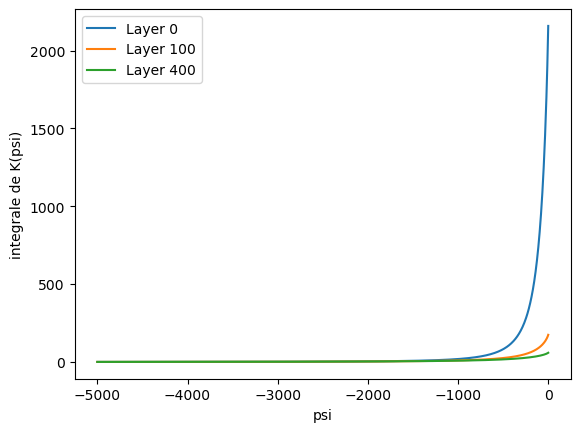

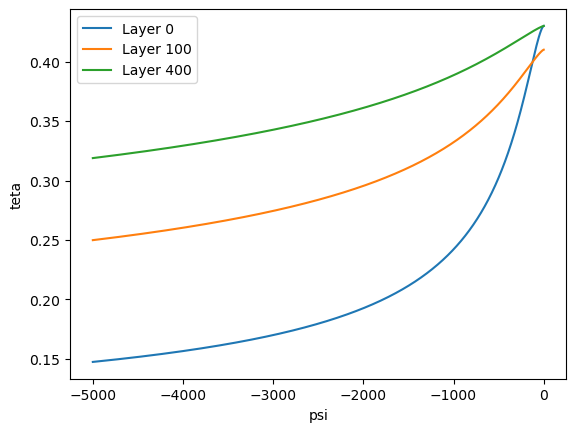

In [7]:

def plot_integrale_K_from_psi(layers):
    psi_values = np.linspace(-5000, 0, 1000)
    for layer in layers:
        plt.plot(psi_values, [layer.integral_lookup_K_from_psi(psi) for psi in psi_values], label=f"Layer {layer.Z}")
    plt.xlabel("psi")
    plt.ylabel("integrale de K(psi)")
    plt.legend()
    plt.show()

plot_integrale_K_from_psi(sol.get_layers())

def plot_teta_from_psi(layers):
    psi_values = np.linspace(-5000, 0, 1000)
    for layer in layers:
        plt.plot(psi_values, [layer.teta_from_psi(psi) for psi in psi_values], label=f"Layer {layer.Z}")
    plt.xlabel("psi")
    plt.ylabel("teta")
    plt.legend()
    plt.show()

plot_teta_from_psi(sol.get_layers())

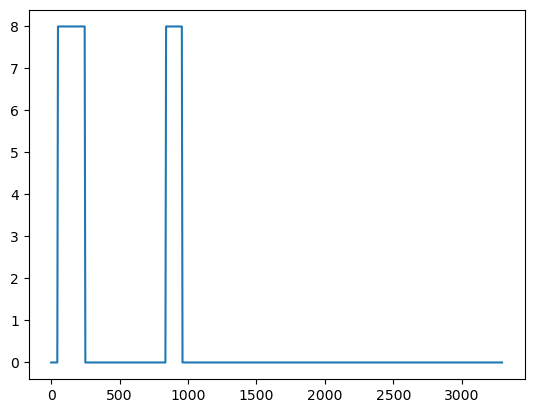

In [8]:
precip_numb = 8 #mm/h
dt = 5 #minutes
total_time = 55*60 #55h in minutes

P = np.zeros(int(total_time/dt))

P[10:50] = precip_numb
P[168:192] = precip_numb

plot_time = np.arange(0, total_time, dt)

plt.plot(plot_time, P)


In [9]:
sol.clear_wetting_fronts()
lgar = LGAR(sol)

for i in range(0, len(P)):
    lgar.step(P[i], dt)

results = lgar.results


/tmp/ipykernel_33970/86411351.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results = pd.concat([self.results, pd.DataFrame([{


In [ ]:
%matplotlib widget
from matplotlib.animation import FuncAnimation


sol.clear_wetting_fronts()
lgar = LGAR(sol)
lgar.time = 0

depth = np.linspace(0, 700, 701)  # Profondeur
psi_array = np.full(depth.shape, psi_init)

# Initialiser le graphique
fig, ax = plt.subplots()
line, = ax.plot(psi_array, depth, 'r')  # Ensure line is correctly unpacked
text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
ax.set_xlabel('Teta')
ax.set_ylabel('Profondeur')
ax.invert_yaxis()  # Inverser l'axe des ordonnées pour que la profondeur augmente vers le bas
ax.set_xlim(0.2, 0.45)
ax.set_ylim(700, 0)

def init():
    text.set_text('')
    return line, text

def update(frame):
    lgar.step(P[frame], dt)
    psi_from_Z = lgar.sol.get_teta_from_Z(depth)
    line.set_xdata(psi_from_Z)
    line.set_ydata(depth)

    text.set_text(f"Time: {lgar.time/60:.2f} h  \n P: {P[frame]:.2f} mm/h")
    return line, text

ani = FuncAnimation(fig, update, frames=range(len(P)), init_func=init, blit=True, repeat=False)

plt.show()

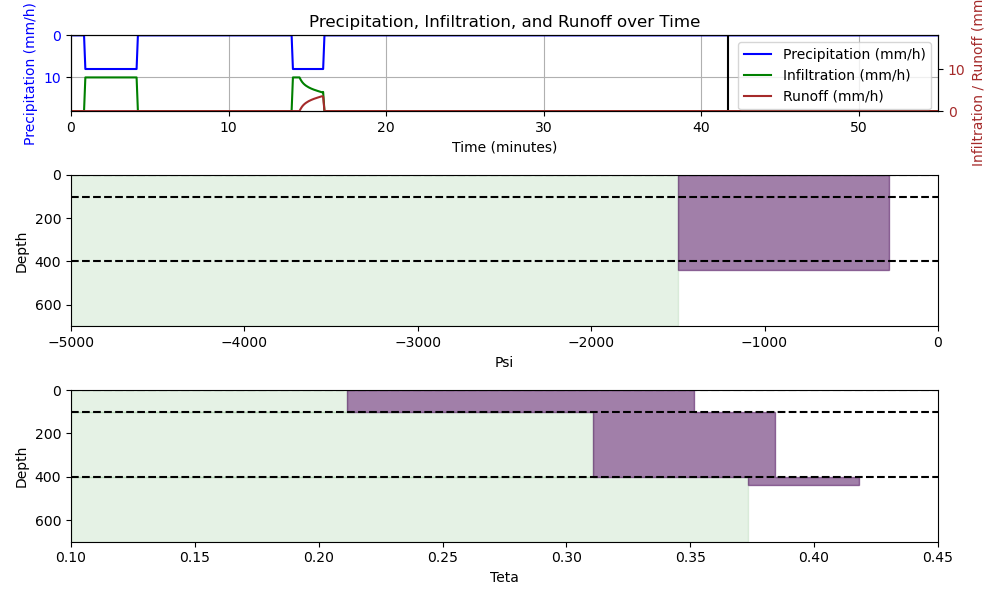

In [59]:
%matplotlib widget
from matplotlib.animation import FuncAnimation
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

plt.close('all')

def plot_precipitation_infiltration_runoff(ax1, results):
    # Convertir les colonnes 'Infiltration' et 'Runoff' en float
    results['Infiltration'] = results['Infiltration'].astype(float)
    results['Runoff'] = results['Runoff'].astype(float)

    # Tracer les précipitations sur l'axe principal avec un axe y inversé
    ax1.plot(results['Time']/60, results['Precipitation'], label='Precipitation (mm/h)', color='b')
    ax1.set_xlabel('Time (minutes)')
    ax1.set_ylabel('Precipitation (mm/h)', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.invert_yaxis()
    ax1.set_ylim(2*max(results['Precipitation']+1), 0)  # Définir l'échelle de l'axe y inversé pour les précipitations

    # Créer un deuxième axe y normal pour l'infiltration et le runoff
    ax2 = ax1.twinx()
    ax2.plot(results['Time']/60, results['Infiltration'], label='Infiltration (mm/h)', color='g')
    ax2.plot(results['Time']/60, results['Runoff'], label='Runoff (mm/h)', color='brown')
    ax2.set_ylabel('Infiltration / Runoff (mm/h)', color='brown')
    ax2.tick_params(axis='y', labelcolor='brown')
    ax2.set_ylim(0, 2*max(results['Infiltration']+1))  # Définir l'échelle de l'axe y normal pour l'infiltration et le ruissellement
    ax1.set_xlim(0, max(results['Time']/60))  # Définir la limite de temps

    # Ajouter des légendes
    fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

    ax1.set_title('Precipitation, Infiltration, and Runoff over Time')
    ax1.grid(True)
    line = ax1.plot([0, 0], [0, 2*max(results['Precipitation']+1)], color='black')[0]
    return line

def plot_layers_depth(ax, x_lim, sol):
    depth = sol.layers[-1].Z+sol.layers[-1].L
    ax.invert_yaxis()
    ax.set_ylabel('Depth')
    ax.set_ylim(depth, 0)
    ax.set_xlim(x_lim)
    for layer in sol.layers:
        ax.plot(x_lim, [layer.Z, layer.Z], 'k--')
    return

def plot_psi_depth(ax, results, sol):
    x_min, x_max = ax.get_xlim()
    depth = sol.layers[-1].Z+sol.layers[-1].L
    wf_rect = []
    psi_init = sol.layers[0].psi_init
    ax.set_xlabel('Psi')
    rect = patches.Rectangle((x_min, 0), psi_init - x_min, depth, alpha=0.1, color='green')
    ax.add_patch(rect)
    max_len = max(len(wf) for wf in results['WettingFronts'])
    
    for wf in range(max_len):
        color = plt.cm.viridis(wf / max_len)  # Utiliser une colormap pour générer des couleurs différentes
        wf_rect.append(patches.Rectangle((0, 0), 0, 0, alpha=0.5, color=color))
        ax.add_patch(wf_rect[wf])
    return wf_rect

def plot_teta_depth(ax, results, sol):
    x_min, x_max = ax.get_xlim()
    depth = sol.layers[-1].Z+sol.layers[-1].L
    wf_poly = []
    psi_init = sol.layers[0].psi_init
    ax.set_xlabel('Teta')
    rect = patches.Rectangle((x_min, 0), psi_init - x_min, depth, alpha=0.1, color='green')
    ax.add_patch(rect)
    for layer in sol.layers:
        teta_l = layer.teta_from_psi(layer.psi_init)
        ax.add_patch(patches.Rectangle((x_min, layer.Z), teta_l - x_min, layer.L, alpha=0.1, color='green'))
        max_len = max(len(wf) for wf in results['WettingFronts'])
    
    for wf in range(max_len):
        color = plt.cm.viridis(wf / max_len)  # Utiliser une colormap pour générer des couleurs différentes
        wf_poly.append(patches.Polygon([[0,0]], closed=True, alpha=0.5, color=color))
        ax.add_patch(wf_poly[wf])
    return wf_poly
    

# Créer une figure avec une grille de subplots
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 2, 2])  # Ajuster les ratios de hauteur

# Créer les subplots
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])

# Appeler la fonction pour chaque subplot
line = plot_precipitation_infiltration_runoff(ax1, results)
plot_layers_depth(ax2, [-5000, 0], sol)
wf_psi_rect = plot_psi_depth(ax2, results, sol)
plot_layers_depth(ax3, [0.1, 0.45], sol)
wf_teta_poly = plot_teta_depth(ax3, results, sol)




def update(frame, line, wf_psi_rect, wf_teta_poly):
    time_x = [results['Time'][frame]/60, results['Time'][frame]/60]
    line.set_xdata(time_x)
    psi_init = sol.layers[0].psi_init
    psi_b = psi_init
    for wf in range(len(wf_psi_rect)):
        if wf < len(results['WettingFronts'][frame]):
            psi = results['WettingFronts'][frame][wf]['psi']
            Z = results['WettingFronts'][frame][wf]['Z']
            pts_teta = [[sol.layers[0].teta_from_psi(psi_b) , 0]]
            for layer in sol.layers:
                L = layer.L if layer.Z + layer.L < Z else Z - layer.Z
                if layer.Z < Z:
                    pts_teta.append([layer.teta_from_psi(psi_b), layer.Z])
                    pts_teta.append([layer.teta_from_psi(psi_b), layer.Z + L])
            for layer in reversed(sol.layers):
                L = layer.L if layer.Z + layer.L < Z else Z - layer.Z
                if layer.Z < Z:
                    pts_teta.append([layer.teta_from_psi(psi), layer.Z + L])
                    pts_teta.append([layer.teta_from_psi(psi), layer.Z])


            
            wf_psi_rect[wf].set_width( psi - psi_b)
            wf_psi_rect[wf].set_height(Z)
            wf_psi_rect[wf].set_xy([psi_b, 0])
            wf_teta_poly[wf].set_xy(pts_teta)
            psi_b = psi

            
        else:
            wf_psi_rect[wf].set_width(0)
            wf_psi_rect[wf].set_height(0)
            wf_psi_rect[wf].set_xy([0, 0])
            wf_teta_poly[wf].set_xy([[0,0]])
    
    
    return line, wf_psi_rect, wf_teta_poly

for i in range(500):
    update(i, line, wf_psi_rect, wf_teta_poly)

ani = FuncAnimation(fig, update, fargs=(line, wf_psi_rect, wf_teta_poly), frames=range(len(results['Time'])), interval=100, blit=True, repeat=False)
plt.tight_layout()
plt.show()